In [1]:
import sys
sys.path.append("../")

In [2]:
from pathlib import Path
from functools import partial

import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from fastai.text import LanguageModelLoader, LanguageModelData
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F

import sentencepiece as spm

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
tokens = joblib.load("../data/tokens_unigram.pkl")

In [4]:
# Filter out empty texts
tokens = [x for x in tokens if x.shape[0] > 0]

In [5]:
# Set shuffle = False to keep sentences from the same paragraph together
trn_tokens, val_tokens = train_test_split(tokens, test_size=0.2, shuffle=False)
val_tokens, tst_tokens = train_test_split(val_tokens, test_size=0.5, shuffle=False)

In [6]:
def get_voc_stats(tokens):
    total_tokens = np.sum([x.shape[0] for x in tokens])
    unks = np.sum([np.sum(x == 0) for x in tokens])
    print("Total tokens: %d\nUnknown Percentage: %.2f %%" % (total_tokens, unks * 100 / total_tokens))
get_voc_stats(tokens)

Total tokens: 82818072
Unknown Percentage: 0.89 %


In [7]:
bptt = 75
batch_size = 64
n_tok = int(np.max([np.max(x) for x in tokens]) + 1)
trn_loader = LanguageModelLoader(
    np.concatenate(trn_tokens), batch_size, bptt)
val_loader = LanguageModelLoader(
    np.concatenate(val_tokens), batch_size, bptt)
tst_loader = LanguageModelLoader(
    np.concatenate(tst_tokens), batch_size, bptt)

In [8]:
sp = spm.SentencePieceProcessor()
sp.Load("../data/unigram_model.model")

True

In [9]:
sp.EncodeAsIds(", 的*")

[4, 5, 0]

In [10]:
np.sum([np.sum(x == 1) for x in tokens]) # <s>

0

In [11]:
np.sum([np.sum(x == 2) for x in tokens]) # </s>

0

In [12]:
sp.DecodeIds(trn_tokens[0].tolist())

'每当 有 涉及 数量 、 结构 、 空间 及 变化 等 方面 的 困难 问题 时 , 通常 就 需要 用 到 数学 工具 去 解决 问题 , 而 这 往往 也 拓展 了 数学 的 研究 范畴 。'

In [13]:
sp.DecodeIds(trn_tokens[1].tolist())

'一 开始 , 数学 的 运用 可见 于 贸易 、 土地 测量 及 之后 的 天文学 。'

In [14]:
from collections import Counter
tmp = []
for i in range(10000):
    for j in range(1, trn_tokens[i].shape[0]):
        if trn_tokens[i][j] == 0:
            tmp.append(trn_tokens[i][j-1])
Counter(tmp).most_common(10)

[(3, 1239),
 (149, 31),
 (3187, 26),
 (4109, 25),
 (29, 20),
 (908, 17),
 (240, 16),
 (133, 15),
 (291, 13),
 (159, 12)]

In [15]:
from collections import Counter
tmp = []
for i in range(10000):
    for j in range(1, trn_tokens[i].shape[0]-1):
        if trn_tokens[i][j] == 4:
            tmp.append(trn_tokens[i][j+1])
Counter(tmp).most_common(10)

[(3, 965),
 (30, 523),
 (24, 461),
 (8, 428),
 (54, 400),
 (41, 359),
 (11, 252),
 (34, 228),
 (205, 219),
 (43, 205)]

In [16]:
sp.DecodeIds([4569])

'胸'

In [17]:
path = Path("../data/cache/lm_unigram/")
path.mkdir(parents=True, exist_ok=True)
model_data = LanguageModelData(
    path, pad_idx=2, n_tok=n_tok, trn_dl=trn_loader, val_dl=val_loader, test_dl=tst_loader
)

In [18]:
n_tok

7500

### QRNN Model

In [21]:
drops = np.array([0.05, 0.1, 0.05, 0, 0.1])
learner = model_data.get_model(
    partial(Adam, betas=(0.8, 0.999)),
    emb_sz=300, n_hid=500, n_layers=4,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=True
)

In [22]:
learner.clip = 25.
learner.lr_find(start_lr=1e-5, end_lr=1, linear=False)
learner.sched.plot()

 18%|█▊        | 1208/6593 [01:56<08:37, 10.41it/s, loss=7.6] 

KeyboardInterrupt: 

In [22]:
lrs = 2e-3
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

epoch      trn_loss   val_loss                                  
    0      4.565469   4.451593  
    1      4.183575   4.027893                                  
    2      4.071145   3.896606                                  
    3      4.008949   3.823468                                  
    4      3.956882   3.769333                                  
    5      3.918282   3.731168                                  
    6      3.894945   3.702762                                  
    7      3.872636   3.680947                                  
    8      3.854972   3.663175                                  
    9      3.843054   3.652749                                  


[3.6527488382143667]

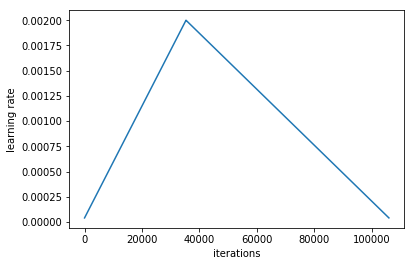

In [23]:
learner.sched.plot_lr()

In [43]:
lrs = 5e-4
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

epoch      trn_loss   val_loss                                  
    0      3.849988   3.651798  
    1      3.843731   3.652289                                  
    2      3.851551   3.653735                                  
    3      3.851972   3.649651                                  
    4      3.841882   3.643531                                  
    5      3.83303    3.639206                                  
 73%|███████▎  | 7710/10598 [12:47<04:47, 10.05it/s, loss=3.81]

KeyboardInterrupt: 

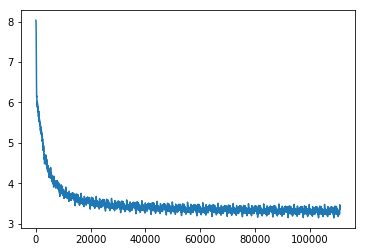

In [14]:
learner.sched.plot_loss()

In [44]:
learner.save("lm_qrnn")
learner.save_encoder("lm_qrnn_enc")

In [ ]:
learner.load("lm_qrnn")

### LSTM

In [19]:
drops = np.array([0.1, 0.1, 0.05, 0, 0.1])
learner = model_data.get_model(
    partial(Adam, betas=(0.8, 0.999)),
    emb_sz=300, n_hid=500, n_layers=3,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=False
)

 88%|████████▊ | 12233/13836 [14:03<01:50, 14.51it/s, loss=20.4]

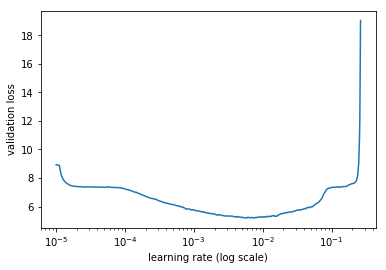

In [20]:
learner.clip = 25.
learner.lr_find(start_lr=1e-5, end_lr=1, linear=False)
learner.sched.plot()

In [21]:
lrs = 2e-3
learner.clip = 10.
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 5), cycle_len=20, use_wd_sched=True)

epoch      trn_loss   val_loss                                  
    0      5.074749   5.08744   
    1      4.656655   4.620055                                  
    2      4.520525   4.496911                                  
    3      4.481254   4.449455                                  
    4      4.424954   4.388754                                  
    5      4.394228   4.343976                                  
    6      4.386279   4.31135                                   
    7      4.339633   4.287091                                  
    8      4.330917   4.264053                                  
    9      4.33403    4.245124                                  
    10     4.308752   4.226011                                  
    11     4.317921   4.212718                                  
    12     4.270177   4.196944                                  
    13     4.264707   4.182222                                  
    14     4.255588   4.169501                           

[4.116772791059771]

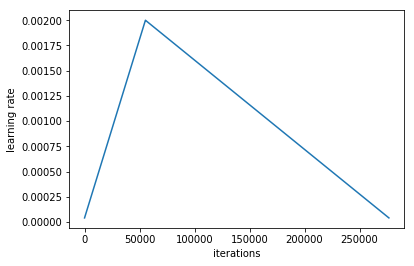

In [22]:
learner.sched.plot_lr()

In [23]:
learner.save("lm_lstm")
learner.save_encoder("lm_lstm_enc")

In [24]:
tmp_iter = iter(trn_loader)

In [25]:
next(tmp_iter)[0].shape

torch.Size([100, 64])

In [26]:
learner.load("lm_lstm")

## Test the model

In [27]:
learner.model.eval()

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(7500, 300, padding_idx=2)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(7500, 300, padding_idx=2)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(300, 500)
      )
      (1): WeightDrop(
        (module): LSTM(500, 500)
      )
      (2): WeightDrop(
        (module): LSTM(500, 300)
      )
    )
    (dropouti): LockedDropout()
    (dropouths): ModuleList(
      (0): LockedDropout()
      (1): LockedDropout()
      (2): LockedDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=300, out_features=7500, bias=False)
    (dropout): LockedDropout()
  )
)

### Next Character Inference

In [28]:
tokens = sp.EncodeAsIds("德国 是 世界 大国 之 一 ， 其 国内 生产 总 值 以 国际 汇率 计")
tokens

[513,
 11,
 314,
 29,
 95,
 45,
 14,
 4,
 51,
 1690,
 712,
 195,
 3,
 1156,
 34,
 354,
 2923,
 450,
 3523]

In [29]:
logits, _, _ = learner.model(T(tokens).unsqueeze(1))
logits.shape

torch.Size([19, 7500])

In [30]:
sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
preds = []
for i in range(1, 4):
      preds.append([sp.IdToPiece(x) for x in sorted_idx[:, -i].tolist()])
# preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
pd.DataFrame({"orig": sp.EncodeAsPieces("德国 是 世界 大国 之 一 ， 其 国内 生产 总 值 以 国际 汇率 计") + [""], 
              "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2]})

,orig,pred_1,pred_2,pred_3
0,▁德国,,,
1,▁是,▁人,▁的,▁
2,▁世界,▁一个,▁一,▁
3,▁大,▁上,▁最,▁第一
4,国,赛,国,气
5,▁之,"▁,",▁。,▁的
6,▁一,▁,▁首,▁父
7,"▁,",▁,▁。,▁大
8,▁其,▁而,▁在,▁
9,▁国内,▁,次,▁目的


In [31]:
def eval(texts):
    learner.model[0].reset()
    tokens =sp.EncodeAsIds(texts)
    logits, _, _ = learner.model(T(tokens).unsqueeze(1))
    sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
    preds = []
    for i in range(1, 4):
          preds.append([sp.IdToPiece(x) for x in sorted_idx[:, -i].tolist()])
    # preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
    return pd.DataFrame({"orig": sp.EncodeAsPieces(texts) + [""], 
                  "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2]})

In [32]:
eval("在 现代 印刷 媒体 ， 卡通 是 一 种 通常 有 幽默 色")

,orig,pred_1,pred_2,pred_3
0,▁在,,,
1,▁现代,▁,▁中国,▁此
2,▁印刷,▁的,▁,▁世界
3,▁媒体,厂,业,▁的
4,"▁,",▁中,▁上,▁的
5,▁卡,▁,▁也,▁在
6,通,通,洛,内
7,▁是,▁的,▁,▁公司
8,▁一,▁一,▁,▁由
9,▁种,▁种,▁部,▁套


In [33]:
eval("对 中国 与 南洋 发动 全面 的 战争 。 1990 年代 ， 中")

,orig,pred_1,pred_2,pred_3
0,▁对,,,
1,▁中国,▁,立,▁此
2,▁与,▁的,▁大陆,▁人
3,▁南,▁中国,▁日本,▁美国
4,洋,韩,▁韩,洋
5,▁发动,▁的,▁地区,▁各国
6,▁全面,▁的,▁战争,▁
7,▁的,▁战争,▁的,▁攻击
8,▁战争,▁战争,▁,▁攻击
9,▁。,"▁,",▁。,▁、


### Generate Sentence

In [34]:
import random

def generate_text(tokens, N=25):    
    preds = []          
    for i in range(N):   
        learner.model[0].reset()          
        logits, _, _ = learner.model(T(tokens).unsqueeze(1))
        probs = F.softmax(logits).data.cpu().numpy()[-1, :]
        candidates = np.argsort(probs)[::-1]
        while True:
            # Sampling
            candidate = np.random.choice(candidates, p=probs[candidates])
            # Greedy
            # candidate = np.argmax(probs[2:]) + 2
            if candidate > 2:
                print(probs[candidates][:3], probs[candidate])
                preds.append(candidate)
                break
        # for candidate in candidates:
        #     if candidate > 1 and ord(itos[candidate]) > 255 and (random.random() < probs[candidate] or probs[candidate] < 0.2):
        #         print(probs[candidate])
        #         preds.append(candidate)
        #         break
        # tokens  = [preds[-1]]# 
        tokens.append(int(preds[-1]))
        # tokens = [:1]
        print(sp.DecodeIds(tokens)) 
    
generate_text(sp.EncodeAsIds("德国 是 世界 大国 之 一 ， 其 国内 生产 总 值 以 国际 汇率 为主 ， "))

[0.05208 0.03808 0.03358] 0.0018540656
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 只有
[0.06039 0.03714 0.02512] 0.0021891166
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 只有 美
[0.08239 0.05494 0.04991] 0.08238611
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 只有 美 、
[0.21    0.15759 0.10468] 0.022674112
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 只有 美 、 苏
[0.5692  0.18353 0.07052] 0.07052022
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 只有 美 、 苏 等
[0.58475 0.06071 0.03751] 0.0021627087
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 只有 美 、 苏 等 强
[0.89562 0.01159 0.00447] 0.8956195
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 只有 美 、 苏 等 强国
[0.14029 0.11542 0.10918] 0.00020717917
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 只有 美 、 苏 等 强国 要求
[0.03651 0.02984 0.01996] 0.00032998098
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 只有 美 、 苏 等 强国 要求 授予
[0.09184 0.04377 0.03593] 0.0038169057
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 只有 美 、 苏 等 强国 要求 授予 在
[0.06473 0.05359 0.04003] 4.9145165e-05
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇

In [35]:
generate_text(sp.EncodeAsIds("在 现代 印刷 媒体 ， 卡通 是 一种 通常 有 幽默 色 "))

[0.73961 0.15849 0.02406] 0.7396053
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色情
[0.49789 0.03914 0.02247] 4.291249e-05
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色情 走
[0.27951 0.14506 0.07668] 0.0016123268
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色情 走状
[0.58237 0.07925 0.03394] 0.58237445
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色情 走状 的
[0.13145 0.02824 0.01819] 0.0047878963
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色情 走状 的 大
[0.11681 0.04444 0.03019] 0.001309693
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色情 走状 的 大宗
[0.24502 0.17397 0.06803] 0.029720532
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色情 走状 的 大宗 作品
[0.48043 0.44047 0.01074] 0.48042804
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色情 走状 的 大宗 作品 ,
[0.06851 0.03699 0.03572] 5.338688e-05
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色情 走状 的 大宗 作品 , 视觉
[0.195   0.1177  0.09199] 0.0020074637
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色情 走状 的 大宗 作品 , 视觉 人物
[0.06103 0.05135 0.03979] 0.016009362
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色情 走状 的 大宗 作品 , 视觉 人物 如
[0.16485 0.01436 0.00962] 0.014357605
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色情 走状 的 大宗 作品 , 视觉 人物 如 :
[0.20752 0.02401 0.01001] 0.002

In [36]:
generate_text(sp.EncodeAsIds("日本 后来 成为 第二次 世界大战 的 轴心国 之一 ， 对 中国 与 南洋 发动 全面 的 战争"))

[0.33627 0.22675 0.03861] 0.33627397
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 ,
[0.04486 0.04287 0.0307 ] 2.1041302e-05
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 , 数百
[0.22174 0.18803 0.18428] 0.22174242
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 , 数百 人
[0.06325 0.05569 0.05105] 0.0025217775
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 , 数百 人 逃
[0.18111 0.1136  0.10861] 0.108613774
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 , 数百 人 逃往
[0.16376 0.10607 0.05897] 3.442174e-05
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 , 数百 人 逃往 两岸
[0.33129 0.2124  0.02399] 0.21240017
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 , 数百 人 逃往 两岸 。
[0.06641 0.044   0.02127] 0.0009601754
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 , 数百 人 逃往 两岸 。 1972
[0.99051 0.00269 0.00211] 0.99051476
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 , 数百 人 逃往 两岸 。 1972年
[0.30696 0.03693 0.03622] 0.036181603
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 , 数百 人 逃往 两岸 。 19

In [37]:
generate_text(sp.EncodeAsIds("特朗普 政府 以为 加征 关税 会 令 中国 屈服 ， 这种 策略 肯定 会 适得其反 ， 如果 就业 和 财富"))

[0.10323 0.07297 0.06288] 5.2419236e-05
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 靠
[0.09258 0.02274 0.02261] 0.0020576685
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 靠 有
[0.12179 0.01353 0.01289] 9.155701e-05
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 靠 有 离开
[0.16025 0.09521 0.06819] 2.8413026e-05
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 靠 有 离开子
[0.24119 0.21934 0.04189] 0.2411898
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 靠 有 离开子 的
[0.0854  0.07665 0.04456] 0.034043938
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 靠 有 离开子 的 能力
[0.69723 0.02978 0.01258] 0.010828357
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 靠 有 离开子 的 能力 而
[0.08722 0.05934 0.0205 ] 0.016003415
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 靠 有 离开子 的 能力 而已
[0.50558 0.41094 0.02946] 0.0001391696
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 靠 有 离开子 的 能力 而已 ——
[0.0689  0.0396  0.02074] 0.0004129345
特朗普 政府 